## Exercise 1. Recap of Online, Batch, and Expectations in ML (regression problem)
### Question b. (i), simulation.

In [1]:
import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt

Implement the task in an environment that you know. Use gradient descent with a small but fixed learning rate η. Follow the convergence of the parameters a and b to their final values.

In [2]:
handpicked_data = [(0, 1)] * 5 + [(0, 5)] * 5 + [(1, 1)] * 5 + [(-1, 5)] * 5 + [(-1, 1)] * 15 + [(1, 5)] * 15
assert len(handpicked_data) == 50

def loss(y, y_pred):
    return torch.mean((y - y_pred)**2)

def f(a, b, x):
    return a * x + b

def make_data_batches(data, batch_size=1):
    i = 0
    batch_list = []
    while i < len(data):
        xs, ys = zip(*data[i:i+batch_size])
        batch_list.append((torch.tensor(xs), torch.tensor(ys)))
        i += batch_size
    return batch_list

def train(data_batches, iterations, lr, init_value=None):
    if init_value is None:   # Initialize a and b with arbitrary value
        init_value = (0., 0.)
    a = torch.tensor(float(init_value[0]), requires_grad=True)
    b = torch.tensor(float(init_value[1]), requires_grad=True)
    n = len(data_batches)
    batch_indices = np.arange(n)
    history = np.zeros((iterations+1, 2))
    # save initial value of a and b to history
    history[0, 0] = a.item()
    history[0, 1] = b.item()
    iteration = 0
    while iteration < iterations:
        if not iteration % n:   # reshuffle the data after having gone through all data points
            np.random.shuffle(batch_indices)
        i = batch_indices[iteration%n]
        x, y = data_batches[i]
        y_pred = f(a, b, x)
        l = loss(y, y_pred)
        # automatically computes the gradients of the loss w.r.t to the learnable parameters a and b
        l.backward()
        # update the parameters based on the gradients
        with torch.no_grad():
            a -= lr * a.grad
            b -= lr * b.grad
        # reset gradients to 0 for next iteration
        a.grad.zero_()
        b.grad.zero_()

        # save the new values of a and b
        history[iteration + 1][0] = a.item()
        history[iteration + 1][1] = b.item()

        iteration += 1
    return history

In [3]:
def plot_a_b(histories, labels, title=None):
    plt.figure()
    for hist, lab in zip(histories, labels):
        plt.plot(hist[:, 0], label="a - "+lab, marker=".")
        plt.plot(hist[:, 1], label="b - "+lab, marker=".")
    plt.xlabel("iterations")
    plt.title(title)
    plt.legend()
    plt.set_cmap("tab10")

def plot_deltab_fluctuations(lrs, histories, label):
    plt.figure()
    fluctuations = []
    for hist in histories:
        n = len(hist)
        # Use only the second half of training, when on average the target value has been reached and the fluctuations can be observed
        delta_b = hist[n//2+1:, 1] - hist[n//2:-1, 1]
        fluctuations.append(np.mean(delta_b**2))
    fluctuations = np.array(fluctuations)
    plt.plot(lrs, fluctuations, linestyle="", marker="+", label="simulation data")
    reg = scipy.stats.linregress(np.log(lrs), np.log(fluctuations))
    plt.plot(lrs, np.exp(reg.intercept) * lrs**reg.slope, label=f"regression fluct={np.exp(reg.intercept):.3g}*eta^{reg.slope:.3g}")
    plt.xlabel("eta")
    plt.ylabel("delta_b fluctuations")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(label)


Compare batch mode (full batch of 50 samples) with online mode (one sample at a time). How do the fluctuations ⟨(∆b)2⟩ scale with η? e.g., linear, quadratic, or other?

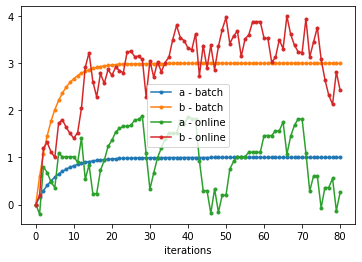

In [4]:
batches_batch = make_data_batches(handpicked_data, batch_size=50)
batches_online = make_data_batches(handpicked_data, batch_size=1)


history_batch = train(batches_batch, 80, 0.1)

history_online = train(batches_online, 80, 0.1)

plot_a_b([history_batch, history_online], ["batch", "online"])

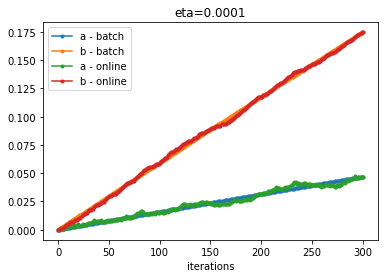

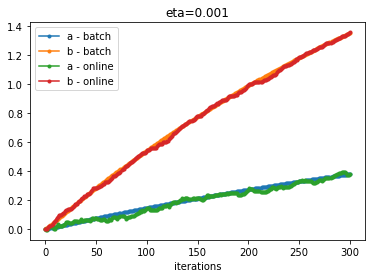

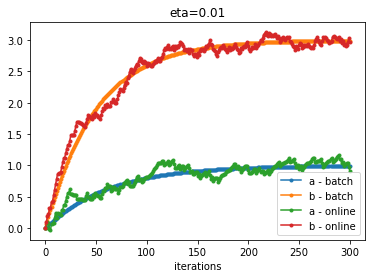

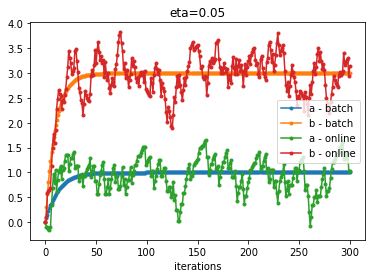

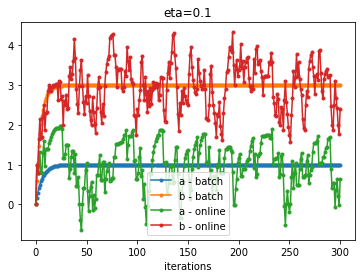

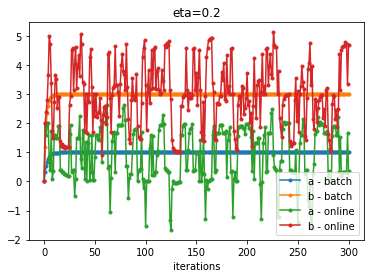

In [5]:
lrs = [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.2]
histories_batch = []
histories_online = []
for lr in lrs:
    hist_b = train(batches_batch, 300, lr)
    hist_o = train(batches_online, 300, lr)
    histories_batch.append(hist_b)
    histories_online.append(hist_o)
    plot_a_b([hist_b, hist_o], ["batch", "online"], title=f"eta={lr}")

_The speed of convergence is the same for batch and online modes, but the online update generates fluctuations around the mean/target value which increase drastically with the learning rate._

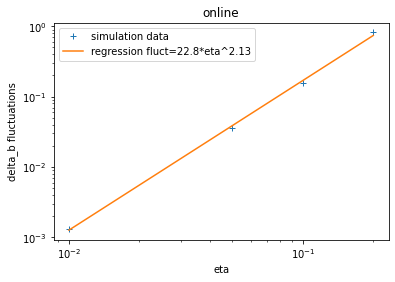

In [6]:
plot_deltab_fluctuations(lrs[2:], histories_online[2:], "online")
# We plot without the first 3 values of eta because there are no fluctuations (convergence is not well reached)

_On the log-log scale plot, we can see that the fluctuations of b are roughly on a line of slope 2, suggesting that the fluctuations scale quadratically with the learning rate η._

Finally, instead of the 50 handpicked examples above, draw N examples randomly and independently from the distribution p(x,y). Run BATCH mode for a small η and observe the final result as a function of N.

In [7]:
def draw_random_data(N):
    xs = np.random.choice([-1, 0, 1], size=N, p=[.4, .2, .4])
    for_m1 = np.random.choice([1, 5], size=N, p=[.75, .25])
    for_1 = np.random.choice([1, 5], size=N, p=[.25, .75])
    for_0 = np.random.choice([1, 5], size=N, p=[.5, .5])
    ys = np.where(xs == -1, for_m1, np.where(xs == 0, for_0, for_1))
    return list(zip(xs, ys))

def plot_final_values(Ns, histories):
    plt.figure()
    plt.plot([Ns[0], Ns[-1]], [3,3], color="grey")
    plt.plot([Ns[0], Ns[-1]], [1,1], color="grey")
    plt.plot(Ns, [h[-1] for h in histories], label=['a', 'b'], marker="+")
    plt.legend()
    plt.xlabel("N")
    plt.xscale("log")
    plt.ylabel("Final values of a and b")

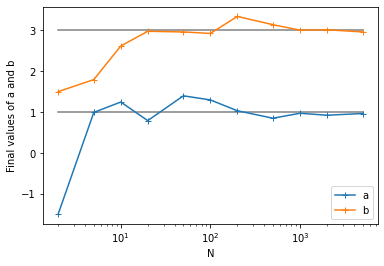

In [8]:
Ns = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
histories = []
for N in Ns:
    data = draw_random_data(N)
    batches = make_data_batches(data, batch_size=N)
    histories.append(train(batches, 300, 0.01))
plot_final_values(Ns, histories)

How close is it to the optimal solution?

_It gets closer to the solution as the batch size increases._

Start exactly at the optimal solution for b that defines the exact minimum of the loss function for N → ∞ but use only a few randomly picked samples. Do you stay at the exact minimum or does the solution move away? How about if you average your solution over 100 update steps? How does the answer to the last two questions change as a function of N?

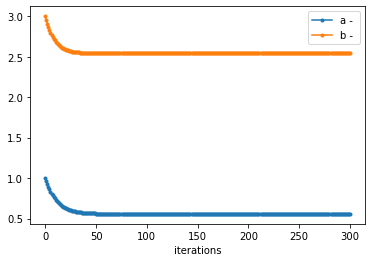

In [9]:
N = 20
data = draw_random_data(N)
batches = make_data_batches(data, batch_size=N)
history = train(batches, 300, 0.05, init_value=(1.,3.))
plot_a_b([history], [""])

_The solution moves away from the exact minimum because the restricted samples define a problem that does not have the same solution as the original problem for  N → ∞.
Because we are in batch mode and there are no fluctuations, averaging over 100 update steps would make no difference._

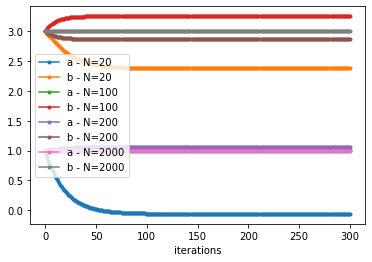

In [12]:
Ns = [20, 100, 200, 2000]
histories = []
labels = []
for N in Ns:
    data = draw_random_data(N)
    batches = make_data_batches(data, batch_size=N)
    history = train(batches, 300, 0.05, init_value=(1.,3.))
    histories.append(history)
    labels.append(f"N={N}")
plot_a_b(histories, labels)

_As N increases, the results move less far away from the exact minimum, because the sampled data better represents the real problem._